In [1]:
# Functionalities are explained in comments where required
# Some lines of codes are also commented that you may uncomment to see some of the results which lead to the final results
# Importing libraries here that are required

import gym
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import spacy
import re
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
env = gym.make("Taxi-v3").env
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



#### There are 4 locations (labeled by different letters), and our job is to pick up the passenger at one location and drop him off at another. We receive +20 points for a successful drop-off and lose 1 point for every time-step it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions."

### Fetching Origing, Destination, and Time of Pickup from the sms data 

In [2]:
#This function gets a string arguement which in our case will be a sentence
#What it does is fetches the origin location, destination, time of travelling
#And returns this information in form of a list

#Evaluation Task 1.Take text from "sms.txt" and fetch pickup and drop from it.

def fetch_pickup_drop(text):
    
    time_of_pickup=re.findall(r'\d{1,2} AM|\d{1,2} PM',text)[0]
    fromloc=re.findall(r'from dwarka sector 23|from dwarka sector 21|from hauz khaas|from airport|airport to|hauz khaas to|dwarka sector 21 to|dwarka sector 23 to',text)
    toloc=re.findall(r'to hauz khaas|to dwarka sector 21|to dwarka sector 23|to airport|for dwarka sector 23|for airport|for dwarka sector 21|for hauz khaas',text)
    origin=re.findall(r'hauz khaas|airport|dwarka sector 21|dwarka sector 23',fromloc[0])[0]
    destination=re.findall(r'hauz khaas|airport|dwarka sector 21|dwarka sector 23',toloc[0])[0]
    #print(origin,destination,time_of_pickup)
    return [origin, destination, time_of_pickup]

In [3]:
env.reset() # reset environment to a new, random state
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


## Summing up the Q-Learning Process
Breaking it down into steps, we get

Initialize the Q-table by all zeros.

Start exploring actions: 

For each state, select any one among all possible actions for the current state (S).

Travel to the next state (S') as a result of that action (a).

For all possible actions from the state (S') select the one with the highest Q-value.

Update Q-table values using the equation.

Set the next state as the current state.

If goal state is reached, then end and repeat the process.


## Exploiting learned values
After enough random exploration of actions, the Q-values tend to converge serving our agent as an action-value function which it can exploit to pick the most optimal action from a given state.

There's a tradeoff between exploration (choosing a random action) and exploitation (choosing actions based on already learned Q-values). We want to prevent the action from always taking the same route, and possibly overfitting, so we'll be introducing another parameter called ϵ "epsilon" to cater to this during training.

Instead of just selecting the best learned Q-value action, we'll sometimes favor exploring the action space further. Lower epsilon value results in episodes with more penalties (on average) which is obvious because we are exploring and making random decisions.

In [4]:
#Initialize Q_table

q_table = np.zeros([env.observation_space.n,env.action_space.n])

In [5]:
#Task-Training the agent
#Train the model using Q learning algorithm on tax v3 environment

#Initializing the hyperparameters
alpha = 0.1
gamma = 0.9
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1,100001):
    state=env.reset()
    
    epochs,penalties,reward=0,0,0
    done=False
    
    while not done:
        if random.uniform(0,1)<epsilon: #choosing between exploration and exploitation
            action=env.action_space.sample()
        else:
            action=np.argmax(q_table[state])
            
        next_state, reward, done, info=env.step(action)
        
        old_value=q_table[state, action]
        next_max=np.max(q_table[next_state])
        
        new_value=(1-alpha)*old_value+alpha*(reward+gamma*next_max) #updating the value
        q_table[state,action]=new_value
        
        if reward==-10:
            penalties+=1
        
        state=next_state
        epochs+=1
        
        if i%100==0:
            clear_output(wait=True)
            print("Episode ",i) #shows progress every 100 episodes of training
        
print("Training completed")

np.save("./q_table.npy", q_table)

Episode  100000
Training completed


In [6]:
#Load trained q_table for evaluation

q_table = np.load("./q_table.npy")

In [7]:
## Create dictionary example, loc_dict['dwarka sector 23] = 0

def create_loc_dict(city_df):
    loc_dict = {}
    
    for index,row in city_df.iterrows():
        #print(row)
        loc_dict[row['location']]=row['mapping']
    
    return loc_dict

In [8]:
#Checks if the pickup and drop location is correct or not

#Evaluation Task 4.Have a check if the fetched pickup, drop is not matching with original pickup, drop given in “orig_df.csv"

def check_pick_up_drop_correction(pick_up, drop, line_num):
    
    orig_df=pd.read_csv('org_df.csv')
    original_origin=orig_df.iloc[line_num]['origin']
    original_destination=orig_df.iloc[line_num]['dest']
    
    if original_origin == pick_up and original_destination == drop:
        return True
    else:
        return False

In [9]:
#Tasks-""Evaluate agent's performance after Q-learning"""

# 1) We need to take text drom "sms.txt" and fetch pickup and drop from it.
# 2) Generate the random state from an enviroment and change the pick up and drop as the fetched one
# 3) Evaluate you q_table performance on all the texts given in sms.txt.
# 4) Have a check if the fetched pickup, drop is not matching with original pickup, drop using orig.csv
# 5) If fetched pickup or/and drop does not match with the original, add penality and reward -10
# 6) Calculate the Total reward, penalities, Wrong pickup/drop predicted and Average time steps per episode.

total_epochs, total_penalties, total_reward, wrong_predictions = 0, 0, 0, 0

info=pd.DataFrame(columns=['origin','destination','time'])
count=0
time_list=[]
f=open("sms.txt","r")
num_of_lines=1000
city=pd.read_csv("city.csv")
#print(city.columns)
loc_dict=create_loc_dict(city)
line_num=0

timeeval={} #stores number of taxis booked at given times
for i in range(1,13):
    timeeval[str(i)+" AM"]=0
    timeeval[str(i)+" PM"]=0
    
    #Evaluation task 3.) Evaluate you model performance on all the texts given in sms.txt. We have generated text for four locations given in city.csv
    
for i in range(1,1001):
    line=f.readline()
    #print(line)
    l=fetch_pickup_drop(line)
    
    # Evaluation Task 1.) We need to take text drom "sms.txt" and fetch pickup and drop from it.
    
    pick_up=l[0]
    drop=l[1]    
    temptime=l[2]
    timeeval[temptime]+=1 #counting how many taxis are booked at given times    
    
    #Evaluation Task 4.) Have a check if the fetched pickup, drop is not matching with original pickup, drop given in “orig_df.csv”
    
    decision=check_pick_up_drop_correction(pick_up,drop,line_num)
    
    #Evaluation Task 5.) If fetched pickup or/and drop does not match with the original, add penalty and reward -10
    
    if not decision:
        total_penalties+=1
        reward-=10
        total_reward+=reward
        wrong_predictions+=1
        
    pickUp_idx=loc_dict[pick_up]
    drop_idx=loc_dict[drop] 
    
    #Evaluation Task 2.) Generate the random state from an environment and change the pick-up and drop as the fetched one from sms.tx
    
    act_state=env.reset()
    
    #print("Actual state ",act_state)    
    #now let's decode the state       
    
    taxi_row,taxi_col,pick_up,drop=env.decode(act_state)
    state=env.encode(taxi_row,taxi_col,int(pickUp_idx),int(drop_idx))
    
    #print("New state generated ",state)
    
    epochs,penalties,reward=0,0,0        
    done=False
    
    while not done:
        
        action=np.argmax(q_table[state])
        state,reward,done,info=env.step(action)
        total_reward+=reward
        
        if reward==-10:
            penalties+=1    
        epochs+=1     
        
     #Evaluation Task 6.) Calculate the Total reward, penalties, Wrong pickup/drop predicted and Average time steps per episode
    
    total_penalties+=penalties
    total_epochs+=epochs
    line_num+=1

In [10]:
#Printing the results i.e Total reward, penalities, Wrong pickup/drop predicted and Average time steps per episode

print(f"Results after {num_of_lines} episodes:")
print(f"Average timesteps per episode: {total_epochs / num_of_lines}")
print(f"Average penalties per episode: {total_penalties / num_of_lines}")
print(f"Total number of wrong predictions", wrong_predictions)
print("Total Reward is", total_reward)

Results after 1000 episodes:
Average timesteps per episode: 13.781
Average penalties per episode: 0.04
Total number of wrong predictions 0
Total Reward is 6859


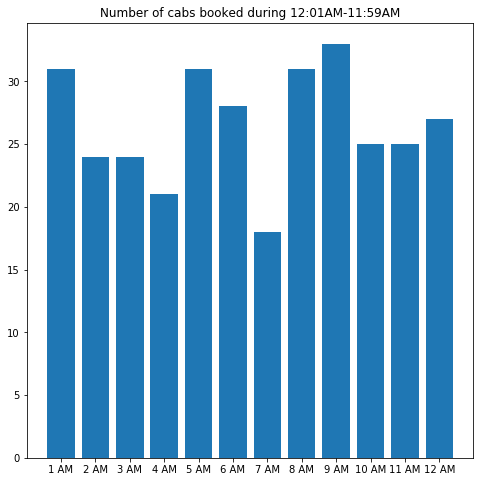

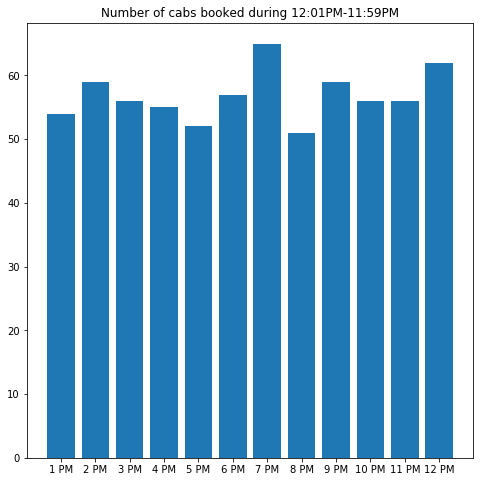

In [11]:
#Plotting the number of cabs booked over time in AM as well as PM

x11 = [(str(i)+" AM") for i in range(1,13)]
x22 = [(str(i)+" PM") for i in range(1,13)]
y11 = [timeeval[i] for i in x11]
y22 = [timeeval[i] for i in x22]
plt.figure(figsize=(8,8))
plt.bar(x11,y11)
plt.title("Number of cabs booked during 12:01AM-11:59AM")
plt.figure(figsize=(8,8))
plt.bar(x22,y22)
plt.title("Number of cabs booked during 12:01PM-11:59PM")
plt.show()

#We can see between 12:01AM-11:59AM the maximum number of cabs booked are around 9AM which makes sense as people leave for work
#We can see between 12:01AM-11:59AM the minimum number of cabs booked are around 7AM as most people are sleeping or at home
#We can see between 12:01PM-11:59PM the maximum number of cabs booked are around 7PM
#We can see between 12:01PM-11:59PM the minimum number of cabs booked are around 8PM

In [12]:
#Conclusion
#Printing the results i.e Total reward, penalities, Wrong pickup/drop predicted and Average time steps per episode

print(f"Results after {num_of_lines} episodes:")
print(f"Average timesteps per episode: {total_epochs / num_of_lines}")
print(f"Average penalties per episode: {total_penalties / num_of_lines}")
print(f"Total number of wrong predictions", wrong_predictions)
print("Total Reward is", total_reward)

Results after 1000 episodes:
Average timesteps per episode: 13.781
Average penalties per episode: 0.04
Total number of wrong predictions 0
Total Reward is 6859
